In [1]:
#%run qsu.ipynb  # color-printing functions
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pymatching import Matching
from qecsim import paulitools as pt
from qecsim.models.generic import DepolarizingErrorModel
from qecsim.models.toric import ToricCode, ToricMWPMDecoder
import qecsim

# initialise models
my_code = ToricCode(5, 5)
my_error_model = DepolarizingErrorModel()
my_decoder = ToricMWPMDecoder()
# print models
print(my_code)
print(my_error_model)
print(my_decoder)

ToricCode(5, 5)
DepolarizingErrorModel()
ToricMWPMDecoder()


In [2]:
# utility functions for use in demo notebooks
from IPython.display import HTML

# namespace
class qsu:
    @staticmethod
    def print_pauli(pauli):
        text = str(pauli)
        text = text.replace('X', '<span style="color:red; font-weight:bold">X</span>')
        text = text.replace('Y', '<span style="color:magenta; font-weight:bold">Y</span>')
        text = text.replace('Z', '<span style="color:blue; font-weight:bold">Z</span>')
        display(HTML('<div class="highlight"><pre style="line-height:1!important;">{}</pre></div>'.format(text))) 

In [3]:
# set physical error probability to 10%
error_probability = 0.1
# seed random number generator for repeatability
rng = np.random.default_rng(0)

# error: random error based on error probability
error = my_error_model.generate(my_code, error_probability, rng)
qsu.print_pauli('error:\n{}'.format(my_code.new_pauli(error)))

In [4]:
# syndrome: stabilizers that do not commute with the error
syndrome = pt.bsp(error, my_code.stabilizers.T)
print(syndrome)
qsu.print_pauli('syndrome:\n{}'.format(my_code.ascii_art(syndrome)))

[1 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 1 1 0 0]


In [5]:
# recovery: best match recovery operation based on decoder
recovery = my_decoder.decode(my_code, syndrome)
qsu.print_pauli('recovery:\n{}'.format(my_code.new_pauli(recovery)))

Failed to load clib: libpypm.so.


In [6]:
# Recovery string: top down, left right (X strings are weird). Horizontal qubits first, vertical qubits last. 
recov_len = len(recovery)
x_recov = recovery[:recov_len // 2]
z_recov = recovery[recov_len // 2:]
print(recovery)
print(x_recov)
print(z_recov)
print(recov_len)

[0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0]
100


In [7]:
# check recovery ^ error commutes with stabilizers (by construction)
print(pt.bsp(recovery ^ error, my_code.stabilizers.T))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
# print recovery ^ error (out of curiosity)
qsu.print_pauli('recovery ^ error:\n{}'.format(my_code.new_pauli(recovery ^ error)))

In [9]:
# success iff recovery ^ error commutes with logicals
print(pt.bsp(recovery ^ error, my_code.logicals.T))

[0 0 0 0]


In [10]:
# repeat demo in single call
from qecsim import app
print(app.run_once(my_code, my_error_model, my_decoder, error_probability=0.15))

{'error_weight': 11, 'success': False, 'logical_commutations': array([1, 0, 0, 1], dtype=int32), 'custom_values': None}


# Renormalization

## Soft decision

In [11]:
print(syndrome)  # syndrome is a numpy array

[1 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 1 1 0 0]


In [12]:
syn_len = len(syndrome)
z_syn = syndrome[:syn_len // 2]  # first half Z syndromes
x_syn = syndrome[syn_len // 2:]  # second half X syndromes **top row is last in list**
print(z_syn)
print(x_syn)

[1 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0]


In [13]:
# This function could be wrong now, have not tested it in a while
def unit_cell(arr, qubit_pos):
    """
    Given an array of qubits, return the unit cell that uses the qubit at qubit_pos as the top of the unit cell.
    
    For an n x n toric code, the qubit array should have 2n^2 qubits. It lists all horizontal qubits first, followed
    by the vertical qubits. The top qubit (at qubit_pos) is always a vertical one. Thus, given a horizontal qubit,
    the vertical qubit diagonal (down left) is given by position +n^2.
    Proceeding down a row is given by position +n. Proceeding to the right is given by position +1.
    
    The unit cell is given as a list of positions in the Z and X syndromes, in that order.
    """
    arr_size = np.size(arr)
    n = int(np.sqrt(arr_size // 2))
    
    cell = np.zeros(12, dtype=int)  # output list of 12 qubit positions
    cell[0] = qubit_pos  # first qubit is the given one (on the top of the unit cell)
    
    # Now proceed top to bottom, left to right, specifying the position of each qubit.
    
    # Next is the 2 horizontal qubits below
    cell[1] = qubit_pos - n**2 + n - 1
    cell[2] = qubit_pos - n**2 + n
    
    # Next are the 3 vertical qubits below that
    cell[3] = qubit_pos + n - 1
    cell[4] = qubit_pos + n
    cell[5] = qubit_pos + n + 1
    
    # 3 horizontal qubits below those 3
    cell[6] = cell[3] - n**2 + n - 1
    cell[7] = cell[4] - n**2 + n - 1
    cell[8] = cell[5] - n**2 + n - 1
    
    # 2 vertical below
    cell[9] = qubit_pos + 2*n - 1
    cell[10] = qubit_pos + 2*n
    
    # Bottom horizontal
    cell[11] = cell[7] + n
    
    # Iterate through all positions and mod by 2n^2 so that indices are in the correct range
    for i in range(12):
        cell[i] %= arr_size
    
    return cell

In [14]:
# Also need to check this one
def unit_stabilizers(cell):
    """
    Given a unit cell (described above), return the positions of the 6 stabilizers (3 X, 3 Z) enclosed within.
    From the syndrome strings, the Z syndromes are the first n^2, X are the last n^2.
    """
    
    # A horizontal qubit position corresponds exactly with the Z stabilizer below it
    # Thus we need to get the 2nd, 3rd, and 8th qubits in the cell
    z_pos = [cell[1], cell[2], cell[7]]
    
    # A vertical qubit corresponds with the X stabilizer below it
    # Thus we need the 1st, 4th, and 5th qubits
    x_pos = [cell[0], cell[3], cell[4]]
    
    return z_pos, x_pos

In [15]:
# cell = unit_cell(np.zeros(98, dtype=int), 53)
# Z_pos, X_pos = unit_stabilizers(cell)
# for i in Z_pos:
#     test[int(i)] = 1
# qsu.print_pauli('test ^ error:\n{}'.format(my_code.new_pauli(test ^ error)))

## Hard decision

In [16]:
def syndrome_to_array(syndrome):
    """
    Converts the syndrome of an n x n code (seen above as a 1D array) to two 2D arrays for X and Z
    """
    arr_size = np.size(syndrome)
    n = int(np.sqrt(arr_size // 2))
    
    z_syn = syndrome[:arr_size // 2]  # first half Z syndromes
    x_syn = syndrome[arr_size // 2:]  # second half X syndromes **top row is last in list**
    
    z_array = np.zeros((n, n), dtype=int)
    x_array = np.zeros((n, n), dtype=int)
    
    counter = 0  # counter to iterate through syndrome
    
    for i in range(n):
        for j in range(n):
            z_array[i, j] = z_syn[counter]
            x_array[i, j] = x_syn[counter]
            counter += 1
            
    # Move the bottom row in list to the top. This fixes some indexing in the recovery string later.
    initial = [i for i in range(n)]
    final = [n-1] + [i for i in range(n-1)]
    x_array[initial, :] = x_array[final, :]
    
    return x_array, z_array

In [17]:
def array_to_syndrome(x_array, z_array):
    """
    Converts the 2D arrays for X and Z syndromes into the syndrome type for qecsim
    """
    # Not needed?

In [18]:
x_syndrome, z_syndrome = syndrome_to_array(syndrome)
print(x_syn)
print("X:\n", x_syndrome)
print(z_syn)
print("Z:\n", z_syndrome)

[1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0]
X:
 [[0 1 1 0 0]
 [1 1 1 0 1]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 0 0]]
[1 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
Z:
 [[1 0 0 0 1]
 [1 0 0 0 1]
 [0 0 1 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [19]:
def array_to_graph(arr):
    """
    Converts n x m array (see above) to the corresponding decoder graph.
    """
    G = nx.Graph()
    n, m = np.shape(arr)
    
    # Add all of the qubits and their syndromes as nodes first
    # NOTE: A node is indexed by its array position (i, j)
    for i in range(n):
        for j in range(m):
            G.add_node((i, j), syndrome=arr[i,j])
    
    # Add the corresponding edges between each node (+/- 1 in the array)
    for i in range(n):
        for j in range(m):
            G.add_edge((i, j), ((i+1)%n, j))
            G.add_edge((i, j), ((i-1)%n, j))
            G.add_edge((i, j), (i, (j+1)%m))
            G.add_edge((i, j), (i, (j-1)%m))
            
    return G

In [20]:
def graph_to_array(G):
    """
    Converts a decoder graph to its corresponding n x m array representation.
    """
    n, m = max(G.nodes)
    n += 1  # Add 1 to fix the zero-indexing
    m += 1
    arr = np.zeros((n, m), dtype=int)
    
    # Build the array by the corresponding syndromes
    for i in range(n):
        for j in range(m):
            arr[i, j] = G.nodes[(i, j)]['syndrome']
            
    return arr

In [21]:
def syndrome_to_graph(syndrome):
    x_array, z_array = syndrome_to_array(syndrome)
    return array_to_graph(x_array), array_to_graph(z_array)

In [22]:
# Probably not needed, recovery string functions are defined later
def graph_to_syndrome(x_graph, z_graph):
    return array_to_syndrome(graph_to_array(x_graph), graph_to_array(z_graph))

In [23]:
x_graph = array_to_graph(x_syndrome)
z_graph = array_to_graph(z_syndrome)

In [24]:
print(graph_to_array(x_graph))

[[0 1 1 0 0]
 [1 1 1 0 1]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 0 0]]


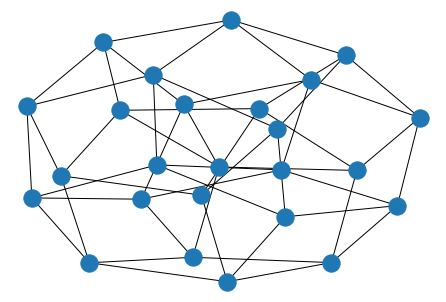

In [25]:
nx.draw(x_graph)

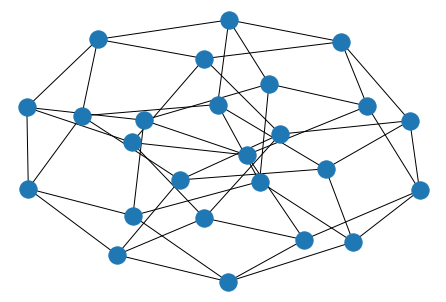

In [26]:
nx.draw(z_graph)

In [27]:
# As of now, perfect measurements means no 3D graph/array, and also no syndrome change history

In [28]:
# This was a function for the array representation, did not factor in the torus wrapping
# def distance(coord1, coord2):
#     Returns the Manhattan distance between two coordinates
#     distance = 0
#     for i in range(np.size(coord1)):
#         distance += abs(coord1[i] - coord2[i])
#     return distance
    
def distance(G, node1, node2):
    """
    Returns the Manhattan distance between two coordinates
    """
    return nx.shortest_path_length(G, node1, node2)

In [29]:
def syndrome_clusters(G, l):
    """
    Returns a list of marked nodes of syndromes with distance l (hard decision level l).
    Algorithm works by looking at the syndrome array. Any nonzero value is a syndrome
    Pick some starting syndrome, check around it in distance l, and add any other syndromes in the radius.
    Continue checking around that new syndrome until the cluster is exhausted.
    Then continue checking with a new starting syndrome (if any).
    If non-square, n,m should be checked to refer to the right dimensions.
    Replace this function with Union-Find.
    """
    clusters = []  # initialize list of clusters
    syn = graph_to_array(G)  # get array for the graph to use numpy
    n, m = max(G.nodes)
    n += 1
    m += 1
    
    nonzero_indices = np.argwhere(syn)  # Get the coordinates of any 1 syndromes
    # Search for clusters as long as there are nonzero syndromes
    while np.shape(nonzero_indices)[0] != 0:
        # Start the cluster
        coord1 = nonzero_indices[0]  # Start at the first nonzero syndrome
        cluster = [coord1]  # Start cluster
        coords = [coord1]  # list of coordinates to check for exhaustive search within radius l
        syn[coord1[0], coord1[1]] = 0  # We've included its index, so set it to 0 to not double count
        
        # Keep checking for distance l until no more new coordinates are added
        while coords:
            coord1 = coords[0]
            # Check for any other with distance l
            distances = [distance(G, tuple(coord1), tuple(coord2)) <= l for coord2 in nonzero_indices]
            # Loop over all and add to cluster
            for i in range(np.size(distances)):
                if distances[i]:
                    coord2 = nonzero_indices[i]
                    # Check if coord2 is in cluster; continue to next loop if it is
                    # Otherwise include coord2 in cluster
                    in_cluster = [np.array_equal(coord2, coord) for coord in cluster]
                    if any(in_cluster):
                        continue
                    cluster.append(coord2)
                    coords.append(coord2)
                    syn[coord2[0], coord2[1]] = 0  # We've included its index, so set it to 0 to not double count
            coords.remove(coord1)  # finished checking this coordinate for distance l
        
        # Add to list and continue to next cluster
        cluster_coords = [tuple(coord) for coord in cluster]
        clusters.append(G.subgraph(cluster_coords))
        nonzero_indices = np.argwhere(syn)
    
    return clusters

In [30]:
test = np.array([[0, 0, 1], [0, 0, 0], [0, 1, 0]])
test_graph = array_to_graph(test)
print(test)

[[0 0 1]
 [0 0 0]
 [0 1 0]]


In [31]:
nonzero_indices = np.argwhere(test)
np.shape(nonzero_indices)[0]

2

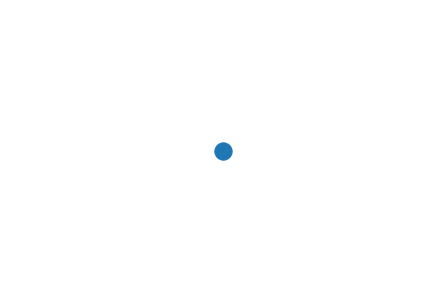

In [32]:
test_clusters = syndrome_clusters(test_graph, 1)
nx.draw(test_clusters[0])

In [33]:
def charge_check(cluster):
    """
    Calculates the total charge of the cluster
    """
    parity = 0
    for node in cluster.nodes:
        parity ^= cluster.nodes[node]['syndrome']  # XOR is only used for bits, should be addition modulo d
    return parity

In [34]:
def fusion(G, cluster, l):
    """
    Determines the edges on which to apply a correction operator assuming that the cluster is neutral.
    Algorithm works by starting at some node, checking for nearby nodes in the list, and pairing the next one.
    Continues this pairing until finished.
    Sometimes some initial node cannot pair everything together and the remaining nodes cannot be made to be <= l
    However, there must be at least one starting position that pairs all nodes with distance <= l
    Thus, we iterate this starting position in case anything goes wrong
    Cluster is a subgraph of G
    """    
    operators = []  # initialize list of correction operators
    syndrome = [tuple(node) for node in cluster.nodes]  # extract the nodes
    num_nodes = len(syndrome)
    counter = 0
    while counter < num_nodes and syndrome:
        operators = []
        syndrome = [node for node in cluster.nodes]  # reinitialize because it gets modified
        start = counter
        for _ in range(num_nodes // 2):
            node1 = syndrome[start]
            # np.where() returns a 2D array of indices of True values
            # Look for nearby nodes of distance <= l
            possible_nodes = np.where([distance(G, node1, node2) <= l and node1 != node2 for node2 in syndrome])
            
            # If there is no other option for node2, try finding another fusion with different start
            if np.shape(possible_nodes)[1] == 0:
                break
            # Otherwise pair node1 and node2
            node2 = syndrome[possible_nodes[0][0]]  # pick the first distinct one
            # The path between node1 and node2 defines the correction
            path = nx.shortest_path(G, node1, node2)
            path_length = len(path)
            for j in range(path_length - 1):
                operator = [path[j], path[j + 1]]
                operators.append(operator)
            syndrome.remove(node1)
            syndrome.remove(node2)
            
            start = max(start-2, 0)  # remove() changes the end indices, so shift it to keep it in bounds
        counter += 1
    return operators

In [35]:
charge_check(test_clusters[0])

1

In [36]:
# Change operator to be the edges
def apply_operator(G, operator):
    """
    An operator is defined by the two ancilla qubits that it acts on
    """
    for node in operator:
        G.nodes[node]['syndrome'] ^= 1  # For qudit, should have addition modulo d and value as input

In [37]:
# Repeat this for both x_graph and z_graph
def find_correction(G, max_level=np.inf):
    """
    Run the hard decision RG decoder for a decoder graph G.
    Algorithm works by starting at l=1, checking for clusters, then fusing if possible. 
    Modifies a newGraph to keep track of the operators that have been chosen already.
    """
    newGraph = G.copy()  # Copy so that we can modify the graph
    syndromes = graph_to_array(newGraph)
    error = np.shape(np.argwhere(syndromes))[0] != 0  # Boolean to keep track if there is still an error
    corrections = []
    l = 0  # initialize RG level at 0, will get += 1 on first loop
    
    # Keep fusing the next level until termination conditions; keep track of operators applied
    while(l < max_level and error):
        l += 1
        clusters = syndrome_clusters(newGraph, l)
        for cluster in clusters:
            if charge_check(cluster) == 0:
                operators = fusion(newGraph, cluster, l)
                for operator in operators:
                    apply_operator(newGraph, operator)  # Save our hard decision by modifying graph
                    corrections.append(operator)
                
        syndromes = graph_to_array(newGraph)
        error = np.shape(np.argwhere(syndromes))[0] != 0
    
    return corrections

In [38]:
print(graph_to_array(x_graph))
z_correction = find_correction(x_graph, max_level=1000)
print(z_correction)

print(graph_to_array(z_graph))
x_correction = find_correction(z_graph, max_level=1000)
print(x_correction)

[[0 1 1 0 0]
 [1 1 1 0 1]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 0 0]]
[[(0, 1), (1, 1)], [(1, 2), (0, 2)], [(1, 4), (1, 0)], [(2, 3), (3, 3)]]
[[1 0 0 0 1]
 [1 0 0 0 1]
 [0 0 1 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[(1, 0), (1, 4)], [(0, 4), (0, 0)], [(2, 3), (2, 2)]]


In [39]:
def operator_type(operator, X_or_Z):
    """
    Again, an operator is defined as the two ancilla qubits whose syndrome it flips. 
    The orientation of these two ancilla determine if it's a horizontal or vertical operator.
    Because of the dual nature, an X operator between 2 vertical qubits is actually a horizontal operator.
    """
    qubit1 = operator[0]
    qubit2 = operator[1]
    
    if X_or_Z == 'Z':
        # Check first coordinate. If same, it is horizontal (recall it is a matrix)
        if qubit1[0] == qubit2[0]:
            return 'H'
        return 'V'
    else:
        # Check first coordinate. If same, it is vertical due to dual
        if qubit1[0] == qubit2[0]:
            return 'V'
        return 'H'

In [40]:
def z_corrections_to_recovery(G, corr):
    """
    Using the graph G and Z corrections corr on G, return the qecsim recovery string representation.
    If non-square, n,m should be checked to refer to the right dimensions.
    """
    n, m = max(G.nodes)
    n += 1
    m += 1
    
    # Determine if the operators are horizontal or vertical
    horizontals = []
    verticals = []
    for operator in corr:
        if operator_type(operator, 'Z') == 'H':
            horizontals.append(operator)
        else:
            verticals.append(operator)
    
    hor_recov = np.zeros(n*m, dtype=int)
    vert_recov = np.zeros(n*m, dtype=int)
    # Iterate through the operators and flip the value in the recovery string
    for operator in horizontals:
        qubit1, qubit2 = operator
        # For Z horizontal operator, the first index is the same
        x = qubit1[0]
        y1, y2 = qubit1[1], qubit2[1]
        
        # x determines which multiple of m the 1D array rounds down to
        # The minimum y is to the left of the data qubit, this determines the residue mod m
        # Minimum does not give the correct one for qubits that wrap around
        hor_recov[x*m + min(y1, y2)] ^= 1
        if abs(y2 - y1) != 1:
            hor_recov[x*m + min(y1, y2)] ^= 1  # reset the incorrect one from above
            hor_recov[x*m + max(y1, y2)] ^= 1  # max will give the correct index
        
    for operator in verticals:
        qubit1, qubit2 = operator
        # For Z vertical operator, the second index is the same
        x1, x2 = qubit1[0], qubit2[0]
        y = qubit1[1]
        
        # Similar to the horizontals, the minimum x is above the data qubit, determines the multiple of m
        vert_recov[m*min(x1, x2) + y] ^= 1
        if abs(x2 - x1) != 1:
            vert_recov[m*min(x1, x2) + y] ^= 1  # reset the incorrect one from above
            vert_recov[m*max(x1, x2) + y] ^= 1  # max will give the correct index
    
    return np.concatenate((hor_recov, vert_recov))

In [41]:
# I'm pretty sure the Z (above) and X (here) functions can be merged into one general function,
# but I found it to be too tedious with if elses to handle the dual nature changing the operators. 
# Maybe there's a cleaner implementation.
def x_corrections_to_recovery(G, corr):
    """
    Using the graph G and Z corrections corr on G, return the qecsim recovery string representation.
    If non-square, n,m should be checked to refer to the right dimensions.
    """
    n, m = max(G.nodes)
    n += 1
    m += 1
    
    # Determine if the operators are horizontal or vertical
    horizontals = []
    verticals = []
    for operator in corr:
        if operator_type(operator, 'X') == 'H':
            horizontals.append(operator)
        else:
            verticals.append(operator)
    
    hor_recov = np.zeros(n*m, dtype=int)
    vert_recov = np.zeros(n*m, dtype=int)
    # Iterate through the operators and flip the value in the recovery string
    for operator in verticals:
        qubit1, qubit2 = operator
        # For X vertical operator, the first index is the same
        x = qubit1[0]
        y1, y2 = qubit1[1], qubit2[1]
        
        # x determines which multiple of m the 1D array rounds down to
        # The minimum y is to the left of the data qubit, this determines the residue mod m
        # Minimum does not give the correct one for qubits that wrap around
        vert_recov[x*m + max(y1, y2)] ^= 1
        if abs(y2 - y1) != 1:
            vert_recov[x*m + max(y1, y2)] ^= 1  # reset the incorrect one from above
            vert_recov[x*m + min(y1, y2)] ^= 1  # max will give the correct index
        
    for operator in horizontals:
        qubit1, qubit2 = operator
        # For X horizontal operator, the second index is the same
        x1, x2 = qubit1[0], qubit2[0]
        x1, x2 = (x1 + 1) % n, (x2 + 1) % n  # For some reason, we need to shift the X operator rows by 1
        y = qubit1[1]
        
        # Similar to the verticals, the minimum x is above the data qubit, determines the multiple of m
        hor_recov[m*min(x1, x2) + y] ^= 1
        if abs(x2 - x1) != 1:
            hor_recov[m*min(x1, x2) + y] ^= 1  # reset the incorrect one from above
            hor_recov[m*max(x1, x2) + y] ^= 1  # max will give the correct index
    
    return np.concatenate((hor_recov, vert_recov))

In [42]:
z_recovery = z_corrections_to_recovery(x_graph, z_correction)
x_recovery = x_corrections_to_recovery(z_graph, x_correction)
HDRG_recovery = np.concatenate((x_recovery, z_recovery))
print(HDRG_recovery)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]


In [43]:
# recovery: best match recovery operation based on decoder
print(recovery)
qsu.print_pauli('recovery:\n{}'.format(my_code.new_pauli(recovery)))

[0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]


In [44]:
print(HDRG_recovery)
qsu.print_pauli('recovery:\n{}'.format(my_code.new_pauli(HDRG_recovery)))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]


In [45]:
recov_len = len(HDRG_recovery)
x_recov = HDRG_recovery[:recov_len // 2]
z_recov = HDRG_recovery[recov_len // 2:]
print(x_recov)
print(z_recov)
print(recov_len)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0]
100


In [46]:
# check recovery ^ error commutes with stabilizers (by construction)
print(pt.bsp(HDRG_recovery ^ error, my_code.stabilizers.T))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [47]:
# print recovery ^ error (out of curiosity)
qsu.print_pauli('recovery ^ error:\n{}'.format(my_code.new_pauli(HDRG_recovery ^ error)))

In [48]:
# success iff recovery ^ error commutes with logicals
print(pt.bsp(HDRG_recovery ^ error, my_code.logicals.T))

[0 0 0 0]


In [49]:
class HDRG(qecsim.model.Decoder):
    def decode(self, code, syndrome, **kwargs):
        """See :meth:`qecsim.model.Decoder.decode`"""
        assert isinstance(code, ToricCode)
        
        # Convert syndrome string to X and Z graphs
        x_graph, z_graph = syndrome_to_graph(syndrome)
        
        # Find the correction operators for X and Z
        # Max level is set to 1000 because any errors with distance > (d-1)/2 run forever
        z_correction = find_correction(x_graph, max_level=1000)
        x_correction = find_correction(z_graph, max_level=1000)
        
        # Convert operators to recovery string
        z_recovery = z_corrections_to_recovery(x_graph, z_correction)
        x_recovery = x_corrections_to_recovery(z_graph, x_correction)
        
        return np.concatenate((x_recovery, z_recovery))

    @property
    def label(self):
        """See :meth:`qecsim.model.Decoder.label`"""
        return 'Hard-decision renormalization group'

In [50]:
HDRG_decoder = HDRG()

In [51]:
# repeat demo in single call
from qecsim import app
print(app.run_once(my_code, my_error_model, HDRG_decoder, error_probability=0.05))

{'error_weight': 5, 'success': True, 'logical_commutations': array([0, 0, 0, 0], dtype=int32), 'custom_values': None}


# Hard-decision local MWPM

In [52]:
def get_nearby(G, cluster, l):
    """
    Given a cluster of nodes, return the NetworkX subgraph containing all nodes within distance l.
    Algorithm works by shifting the current coordinate iteratively.
    If non-square, n,m should be checked to refer to the right dimensions.
    """
    n, m = max(G.nodes)
    n += 1
    m += 1
    cluster_coords = {node for node in cluster.nodes}  # set of coordinates within distance l
    
    # Loop through nodes in the cluster and add everything within distance l
    for node in cluster.nodes:
        coord = tuple(node)
        x = coord[0]
        y = coord[1]
        
        # Generate possible shifts of up to distance l, inclusive
        for i in range(-l, l+1):
            for j in range(-l, l+1):
                if abs(i) + abs(j) <= l:
                    cluster_coords.add(((x+i)%n, (y+j)%m))  # Add the shifted coordinate
                    cluster_coords.add(((x+j)%n, (y+i)%m))  # Add the symmetric shifted coordinate
    return G.subgraph(list(cluster_coords))

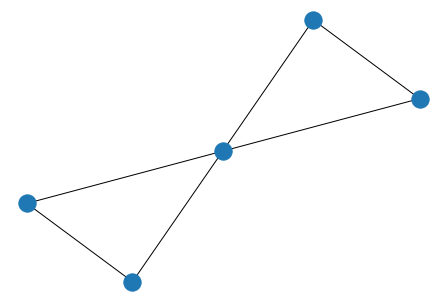

In [53]:
near = get_nearby(test_graph, test_clusters[0], 1)
nx.draw(near)

In [54]:
def nx_to_match(G, lookup_dicts=False):
    """
    Converts a NetworkX decoder graph to its corresponding PyMatching graph.
    Optionally return lookup dictionaries for converting between node and edge labels.
    """
    # First set an ordering on the nodes and build the lookup dictionary
    node_order = sorted(G.nodes())
    node_lookup = {i: node_order[i] for i in range(len(node_order))}
    
    # Use NetworkX command to get a copy of G with integer labels
    newG = nx.convert_node_labels_to_integers(G, ordering="sorted")
    
    # PyMatching needs edges to have the qubit_id attribute for decoding
    # First set an order, and build a lookup dictionary for that as well
    # Then add the edge attribute according to the order
    # Note: alternative implementation of edge_lookup: use node_lookup now instead of integer labels
    edge_order = sorted(newG.edges())
    edge_lookup = {i: edge_order[i] for i in range(len(edge_order))}
    for i in range(len(edge_order)):
        newG.edges[edge_order[i]]['qubit_id'] = i
        # Note: edge weights can be added here as desired by including a parameter 'weight'
    
    return (Matching(newG), node_lookup, edge_lookup) if lookup_dicts else Matching(newG)

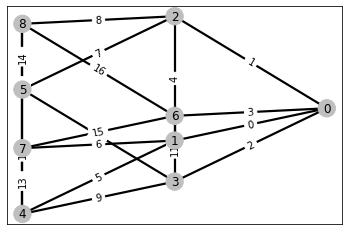

In [55]:
test_match, node_lookup, edge_lookup = nx_to_match(test_graph, lookup_dicts=True)
test_match.draw()

In [56]:
def syndrome_to_match(G, node_lookup):
    """
    Given syndromes in the nodes of G, return the syndrome vector for PyMatching using node_lookup
    """
    syndrome = np.zeros(len(node_lookup), dtype=int)  # initialize syndrome vector
    inv_node_lookup = {v: k for k, v in node_lookup.items()}  # need to obtain ID of the qubits
    # Iterate through and flip the syndrome vector according to the syndromes in G
    for node in G.nodes:
        syndrome[inv_node_lookup[tuple(node)]] = G.nodes[node]['syndrome']
    return syndrome

In [57]:
match_syndrome = syndrome_to_match(test_graph, node_lookup)
print(match_syndrome)

# Decoding step
match_correction = test_match.decode(match_syndrome)

print(test_match)
print(node_lookup)
print(edge_lookup)
print(match_correction)

[0 0 1 0 0 0 0 1 0]
<pymatching.Matching object with 18 qubits, 9 stabilisers, 0 boundary nodes, and 18 edges>
{0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (1, 0), 4: (1, 1), 5: (1, 2), 6: (2, 0), 7: (2, 1), 8: (2, 2)}
{0: (0, 1), 1: (0, 2), 2: (0, 3), 3: (0, 6), 4: (1, 2), 5: (1, 4), 6: (1, 7), 7: (2, 5), 8: (2, 8), 9: (3, 4), 10: (3, 5), 11: (3, 6), 12: (4, 5), 13: (4, 7), 14: (5, 8), 15: (6, 7), 16: (6, 8), 17: (7, 8)}
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1]


In [58]:
def match_correction_to_operators(correction, node_lookup, edge_lookup):
    """
    Given a Matching vector of corrections, use node_lookup and edge_lookup to return the correction operators.
    """
    # correction has 1 at the position of the qubit_id corresponding to that operator
    # Use lookup dictionaries to convert back into the operator [(a, b), (c, d)]
    
    operators = []
    for i in range(len(correction)):
        if correction[i]:
            # Get the correction operator by edge_lookup
            # Note: if using alternative implementation of edge_lookup, no need for node_lookup here
            edge = edge_lookup[i]
            operators.append([node_lookup[edge[0]], node_lookup[edge[1]]])
    return operators

In [59]:
match_operators = match_correction_to_operators(match_correction, node_lookup, edge_lookup)
print(match_operators)

[[(0, 2), (2, 2)], [(2, 1), (2, 2)]]


In [60]:
# Repeat this for both x_graph and z_graph
def find_correction_MWPM(G, max_level=np.inf):
    """
    Run the hard decision RG decoder with local MWPM corrections for a decoder graph G.
    Algorithm works by starting at l=1, checking for clusters, then fusing if possible. 
    Modifies a newGraph to keep track of the operators that have been chosen already.
    """
    newGraph = G.copy()  # Copy so that we can modify the graph
    syndromes = graph_to_array(newGraph)
    error = np.shape(np.argwhere(syndromes))[0] != 0  # Boolean to keep track if there is still an error
    corrections = []
    l = 0  # initialize RG level at 0, will get += 1 on first loop
    # Can make full matching object here instead of for new cluster
    # Use MWPM on local clusters at each level until termination conditions; keep track of operators applied
    while(l < max_level and error):
        l += 1
        clusters = syndrome_clusters(newGraph, l)
        for cluster in clusters:
            if charge_check(cluster) == 0:
                # Get all nearby nodes of the cluster for MWPM. Not necessary for full Matching object
                nearby = get_nearby(newGraph, cluster, l)
                
                # Convert to PyMatching object
                match_graph, node_lookup, edge_lookup = nx_to_match(nearby, lookup_dicts=True)
                
                # Convert the NetworkX syndrome to PyMatching syndrome then decode it
                match_syndrome = syndrome_to_match(nearby, node_lookup)
                match_correction = match_graph.decode(match_syndrome)
                
                # Convert the PyMatching output to our operator language
                operators = match_correction_to_operators(match_correction, node_lookup, edge_lookup)
                
                # Continue just as in HDRG
                for operator in operators:
                    apply_operator(newGraph, operator)  # Save our hard decision by modifying graph
                    corrections.append(operator)
                
        syndromes = graph_to_array(newGraph)
        error = np.shape(np.argwhere(syndromes))[0] != 0
    
    return corrections

In [61]:
class HDRG_MWPM(qecsim.model.Decoder):
    def decode(self, code, syndrome, **kwargs):
        """See :meth:`qecsim.model.Decoder.decode`"""
        assert isinstance(code, ToricCode)
        
        # Convert syndrome string to X and Z graphs
        x_graph, z_graph = syndrome_to_graph(syndrome)
        
        # Find the correction operators for X and Z
        # Max level is set to 1000 because any errors with distance > (d-1)/2 run forever
        z_correction = find_correction_MWPM(x_graph, max_level=1000)
        x_correction = find_correction_MWPM(z_graph, max_level=1000)
        
        # Convert operators to recovery string
        z_recovery = z_corrections_to_recovery(x_graph, z_correction)
        x_recovery = x_corrections_to_recovery(z_graph, x_correction)
        
        return np.concatenate((x_recovery, z_recovery))

    @property
    def label(self):
        """See :meth:`qecsim.model.Decoder.label`"""
        return 'Hard-decision renormalization group with local MWPM'

In [62]:
HDRG_MWPM_decoder = HDRG_MWPM()
# repeat demo in single call
from qecsim import app
print(app.run_once(my_code, my_error_model, HDRG_MWPM_decoder, error_probability=0.15))

{'error_weight': 7, 'success': True, 'logical_commutations': array([0, 0, 0, 0], dtype=int32), 'custom_values': None}


In [63]:
%matplotlib inline
import collections
import itertools
from qecsim import app

In [64]:
def threshold_plot(codes, error_model, decoder, error_probability_min, error_probability_max, max_runs, error_probability_space=20):
    """
    Run a threshold simulation on these parameters
    """
    error_probabilities = np.linspace(error_probability_min, error_probability_max, error_probability_space)
    # print run parameters
    print('Codes:', [code.label for code in codes])
    print('Error model:', error_model.label)
    print('Decoder:', decoder.label)
    print('Error probabilities:', error_probabilities)
    print('Maximum runs:', max_runs)
    
    # run simulations and print data from middle run to view format
    data = [app.run(code, error_model, decoder, error_probability, max_runs=max_runs)
            for code in codes for error_probability in error_probabilities]
    print(data[len(data)//2])
    
    # prepare code to x,y map and print
    code_to_xys = {}
    for run in data:
        xys = code_to_xys.setdefault(run['code'], [])
        xys.append((run['physical_error_rate'], run['logical_failure_rate']))
    print('\n'.join('{}: {}'.format(k, v) for k, v in code_to_xys.items()))
    
    # format plot
    fig = plt.figure(1, figsize=(12, 9))
    plt.title('Toric code simulation\n({} error model, {} decoder)'.format(error_model.label, decoder.label))
    plt.xlabel('Physical error rate')
    plt.ylabel('Logical failure rate')
    plt.xlim(error_probability_min-0.05, error_probability_max+0.05)
    plt.ylim(-0.05, 0.85)
    # add data
    for code, xys in code_to_xys.items():
        #plt.plot(*zip(*xys), 'x-', label='{} code'.format(code))
        plt.errorbar(*zip(*xys), fmt='x-', label='{} code'.format(code), yerr=1/np.sqrt(max_runs), capsize=4)
    plt.legend(loc='lower right')
    plt.show()

In [65]:
# set models
codes = [ToricCode(*size) for size in [(4, 4), (6, 6), (8, 8), (10, 10)]]
error_model = DepolarizingErrorModel()
MWPM_decoder = ToricMWPMDecoder()
# set physical error probabilities
error_probability_min, error_probability_max = 0, 0.2

# set max_runs for each probability
max_runs = 5000

Codes: ['Toric 4x4', 'Toric 6x6', 'Toric 8x8', 'Toric 10x10']
Error model: Depolarizing
Decoder: Toric MWPM
Error probabilities: [0.         0.01052632 0.02105263 0.03157895 0.04210526 0.05263158
 0.06315789 0.07368421 0.08421053 0.09473684 0.10526316 0.11578947
 0.12631579 0.13684211 0.14736842 0.15789474 0.16842105 0.17894737
 0.18947368 0.2       ]
Maximum runs: 5000
{'code': 'Toric 8x8', 'n_k_d': (128, 2, 8), 'time_steps': 1, 'error_model': 'Depolarizing', 'decoder': 'Toric MWPM', 'error_probability': 0.0, 'measurement_error_probability': 0.0, 'n_run': 5000, 'n_success': 5000, 'n_fail': 0, 'n_logical_commutations': (0, 0, 0, 0), 'custom_totals': None, 'error_weight_total': 0, 'error_weight_pvar': 0, 'logical_failure_rate': 0.0, 'physical_error_rate': 0.0, 'wall_time': 6.28941599999996}
Toric 4x4: [(0.0, 0.0), (0.01055, 0.0014), (0.0208375, 0.0094), (0.032225, 0.0226), (0.0418, 0.0412), (0.05283125, 0.0756), (0.06435, 0.108), (0.07391875, 0.1322), (0.0847, 0.1798), (0.0952875, 0.225

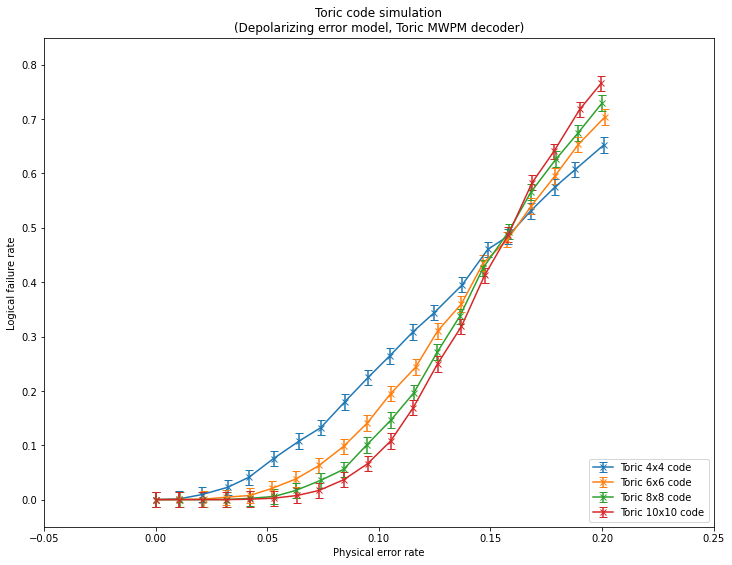

In [57]:
threshold_plot(codes, error_model, MWPM_decoder, error_probability_min, error_probability_max, max_runs)

Codes: ['Toric 4x4', 'Toric 6x6', 'Toric 8x8', 'Toric 10x10']
Error model: Depolarizing
Decoder: Hard-decision renormalization group
Error probabilities: [0.         0.01052632 0.02105263 0.03157895 0.04210526 0.05263158
 0.06315789 0.07368421 0.08421053 0.09473684 0.10526316 0.11578947
 0.12631579 0.13684211 0.14736842 0.15789474 0.16842105 0.17894737
 0.18947368 0.2       ]
Maximum runs: 5000
{'code': 'Toric 8x8', 'n_k_d': (128, 2, 8), 'time_steps': 1, 'error_model': 'Depolarizing', 'decoder': 'Hard-decision renormalization group', 'error_probability': 0.0, 'measurement_error_probability': 0.0, 'n_run': 5000, 'n_success': 5000, 'n_fail': 0, 'n_logical_commutations': (0, 0, 0, 0), 'custom_totals': None, 'error_weight_total': 0, 'error_weight_pvar': 0, 'logical_failure_rate': 0.0, 'physical_error_rate': 0.0, 'wall_time': 29.54234130000077}
Toric 4x4: [(0.0, 0.0), (0.01028125, 0.002), (0.02125625, 0.0102), (0.03174375, 0.0242), (0.04193125, 0.0422), (0.05434375, 0.07), (0.06264375, 0.09

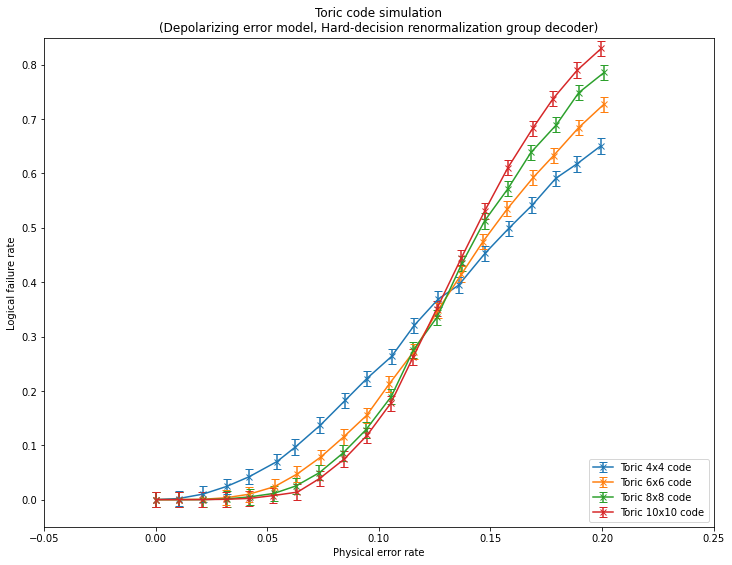

In [58]:
threshold_plot(codes, error_model, HDRG_decoder, error_probability_min, error_probability_max, max_runs)

Codes: ['Toric 4x4', 'Toric 6x6', 'Toric 8x8', 'Toric 10x10']
Error model: Depolarizing
Decoder: Hard-decision renormalization group with local MWPM
Error probabilities: [0.         0.01052632 0.02105263 0.03157895 0.04210526 0.05263158
 0.06315789 0.07368421 0.08421053 0.09473684 0.10526316 0.11578947
 0.12631579 0.13684211 0.14736842 0.15789474 0.16842105 0.17894737
 0.18947368 0.2       ]
Maximum runs: 5000
{'code': 'Toric 8x8', 'n_k_d': (128, 2, 8), 'time_steps': 1, 'error_model': 'Depolarizing', 'decoder': 'Hard-decision renormalization group with local MWPM', 'error_probability': 0.0, 'measurement_error_probability': 0.0, 'n_run': 5000, 'n_success': 5000, 'n_fail': 0, 'n_logical_commutations': (0, 0, 0, 0), 'custom_totals': None, 'error_weight_total': 0, 'error_weight_pvar': 0, 'logical_failure_rate': 0.0, 'physical_error_rate': 0.0, 'wall_time': 31.687797299999147}
Toric 4x4: [(0.0, 0.0), (0.010575, 0.0022), (0.020775, 0.0114), (0.03226875, 0.0234), (0.041775, 0.044), (0.0524812

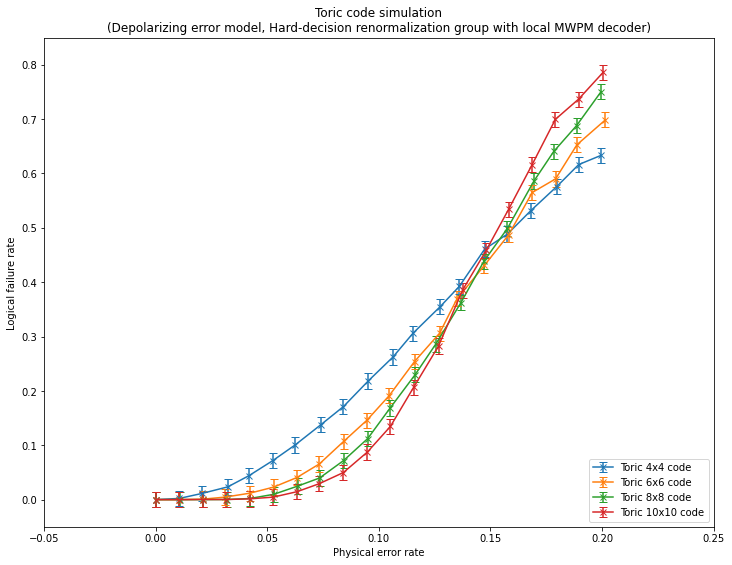

In [66]:
threshold_plot(codes, error_model, HDRG_MWPM_decoder, error_probability_min, error_probability_max, max_runs)

# Figures for paper, assumes Toric 5x5 and rng seed 0

In [66]:
# Stabilizer measurements
recovery = my_decoder.decode(my_code, syndrome)
x_flip = [17, 18, 38, 43]
for i in x_flip:
    recovery[i] ^= 1
qsu.print_pauli('{}'.format(my_code.new_pauli(recovery ^ error)))

In [67]:
# Ancilla qubits of the stabilizers above
example_syndrome = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
qsu.print_pauli('{}'.format(my_code.ascii_art(example_syndrome)))

In [68]:
# Logical operators
recovery = my_decoder.decode(my_code, syndrome)
x_flip = [27, 32, 37, 42, 47]
z_flip = [51, 56, 76, 77, 60, 61, 62, 63, 64]
for i in x_flip:
    recovery[i] ^= 1
for i in z_flip:
    recovery[i] ^= 1
qsu.print_pauli('{}'.format(my_code.new_pauli(recovery ^ error)))

In [69]:
# Single error
single_error = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
qsu.print_pauli('{}'.format(my_code.new_pauli(single_error)))

In [70]:
# Syndrome of single error
single_syndrome = pt.bsp(single_error, my_code.stabilizers.T)
qsu.print_pauli('{}'.format(my_code.ascii_art(single_syndrome)))

In [71]:
# Error chain
error_chain = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
qsu.print_pauli('{}'.format(my_code.new_pauli(error_chain)))

In [72]:
# Syndrome of error chain
syndrome_chain = pt.bsp(error_chain, my_code.stabilizers.T)
qsu.print_pauli('{}'.format(my_code.ascii_art(syndrome_chain)))

In [73]:
# Error to get stabilizer
error_stab = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
qsu.print_pauli('{}'.format(my_code.new_pauli(error_stab)))

In [74]:
# Recovery operation on error to get a stabilizer
syndrome_stab = pt.bsp(error_stab, my_code.stabilizers.T)
recovery_stab = my_decoder.decode(my_code, syndrome_stab)
qsu.print_pauli('{}'.format(my_code.new_pauli(recovery_stab)))

In [75]:
# Product is a stabilizer
qsu.print_pauli('{}'.format(my_code.new_pauli(recovery_stab ^ error_stab)))

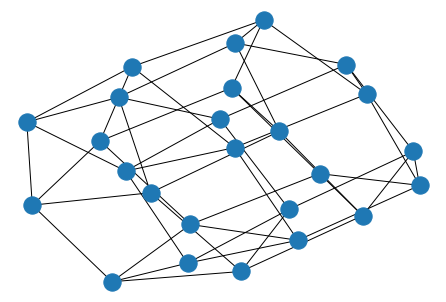

In [76]:
decoder_graph = array_to_graph(syndrome_to_array(syndrome)[0])
nx.draw(decoder_graph)

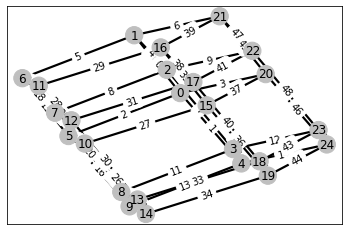

In [77]:
matching_graph = nx_to_match(decoder_graph)
matching_graph.draw()

In [78]:
# Error chain to show distance 1 cluster
error_cluster1 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
qsu.print_pauli('{}'.format(my_code.new_pauli(error_cluster1)))
# Syndrome of distance 1
syndrome_cluster1 = pt.bsp(error_cluster1, my_code.stabilizers.T)
qsu.print_pauli('{}'.format(my_code.ascii_art(syndrome_cluster1)))

In [79]:
# Error chain to show distance 2 cluster
error_cluster2 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
qsu.print_pauli('{}'.format(my_code.new_pauli(error_cluster2)))
# Syndrome of distance 2
syndrome_cluster2 = pt.bsp(error_cluster2, my_code.stabilizers.T)
qsu.print_pauli('{}'.format(my_code.ascii_art(syndrome_cluster2)))